# Hyper Parameter Optimisation

In [43]:
import pickle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from robo.fmin import bayesian_optimization

rf = pickle.load(open("./rf_surrogate_cnn.pkl", "rb"))
cost_rf = pickle.load(open("./rf_cost_surrogate_cnn.pkl", "rb"))

def objective_function(x, epoch=40):
    """
        Function wrapper to approximate the validation error of the hyperparameter configurations x by the 
        prediction of a surrogate regression model, which was trained on the validation error of randomly sampled 
        hyperparameter configurations. The original surrogate predicts the validation error after a given epoch. 
        Since all hyperparameter configurations were trained for a total amount of 
        40 epochs, we will query the performance after epoch 40.
    """
    
    # Normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = rf.predict(x_norm[None, :])[0]

    return y

def runtime(x, epoch=40):
    """
        Function wrapper to approximate the runtime of the hyperparameter configurations x.
    """
    
    # Normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = cost_rf.predict(x_norm[None, :])[0]

    return y


/home/jochen/tensorflow/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jochen/tensorflow/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [123]:
# field for small tests
HyperConfig = []
HyperConfig.append(-2.9)  # 10e of learning rate in range [−6,0]
HyperConfig.append(64)  # batch size in [32, 512]
HyperConfig.append(8)   # 2e in [4, 10] number of filters layer 1
HyperConfig.append(9)   # 2e in [4, 10] number of filters layer 2
HyperConfig.append(9)   # 2e in [4, 10] number of filters layer 3

v_err = objective_function(HyperConfig)   # calculate validation error
rt = runtime(HyperConfig)
print(v_err, rt)

0.166891790607 392.054472609


In [97]:
BestConfig = [-3,64,5,5,5]   # initialise List with arbitrary values

# sample hyperparameters randomly
rand_incumbents = []      # list of 10 lists with 50 iterations each
totalincumbent = 1        # initialise incumbent over all loops
rand_runtimes = []            # list of 50, evaluate only in first of 10 external loops
for i in range(10):
    rand_incumbents.append([])    # ad next empty list (to be filled with 50 entries)
    incumbent = 1     # initialse incumbent of inner loop over 50 iterations
    for j in range(50):
        HyperConfig = [np.random.uniform(-6, 0),
                       np.random.uniform(0, 64),
                       np.random.uniform(4, 10),
                       np.random.uniform(4, 10),
                       np.random.uniform(4, 10)]
        v_err = objective_function(HyperConfig)
        incumbent = min(incumbent,v_err)
        rand_incumbents[-1].append(incumbent)
        if (i==0):   # storing runtime only for first of the 10 loops
            rand_runtimes.append(runtime(HyperConfig))
        # check for best incumbent over inner and outer loop. update best guess für HyperConfig
        if v_err < totalincumbent:
            BestConfig = HyperConfig
            totalincumbent = v_err


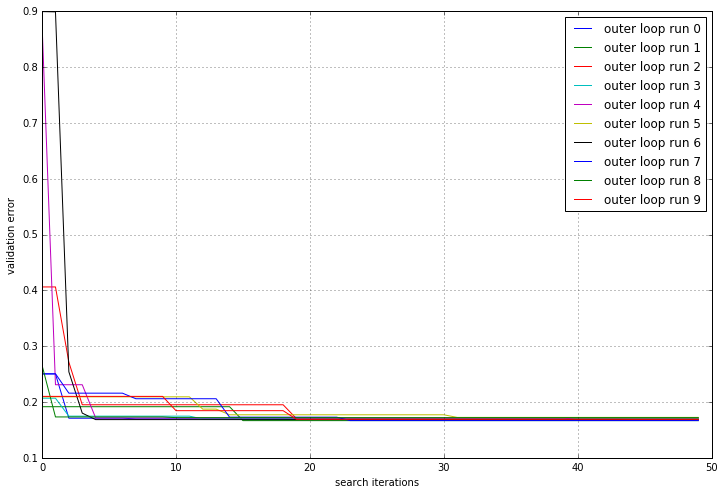

In [98]:
plt.figure(figsize=(12, 8))
for i, incs in enumerate(rand_incumbents):
    plt.plot(incs, label="outer loop run {}".format(i))
plt.grid(True)
# plt.yscale('log')
plt.xlabel("search iterations")
plt.ylabel("validation error")
plt.legend(loc='best')

In [89]:
# http://automl.github.io/RoBO/tutorials.html#blackbox-function-optimization-with-robo
bay_incumbents = []      # list of 10 lists with 50 iterations each
bay_runtimes = []
bay_results = []
for i in range(10):
    lower = np.array([-6,0,4,4,4])
    upper = np.array([0,64,10,10,10])    
    result = bayesian_optimization(objective_function, lower, upper, num_iterations=50)
    bay_results.append(result)  # store complete list of results, even if not required for assigments
    bay_incumbents.append(result['incumbent_values'])
    if (i==0):     # runtime evaluation only in first loop
        datapoints = result['X']   # get list of configurations evaluated by bayesian_optimisation()
        for HyperConfig in result['X']:
            bay_runtimes.append(runtime(HyperConfig))  # for each entry evaluate the runtime assumed by surrogate model

    print("run {} completed".format(i))

run 0 completed
run 1 completed
run 2 completed
run 3 completed
run 4 completed
run 5 completed
run 6 completed
run 7 completed
run 8 completed
run 9 completed


In [90]:
print("incumbents \n", bay_incumbents)
print("first results Datapoints \n", bay_results[0]['X'])
print("runtimes \n", bay_runtimes)
print("cum runtimes \n", np.cumsum(bay_runtimes))

incumbents 
 [[0.20009886749779757, 0.20009886749779757, 0.20009886749779757, 0.19476442462013874, 0.19476442462013874, 0.19476442462013874, 0.19476442462013874, 0.19476442462013874, 0.19476442462013874, 0.19476442462013874, 0.17028873879292272, 0.17028873879292272, 0.17028873879292272, 0.17028873879292272, 0.17028873879292272, 0.17028873879292272, 0.16892315292543084, 0.16892315292543084, 0.16892315292543084, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612789427960595, 0.1612

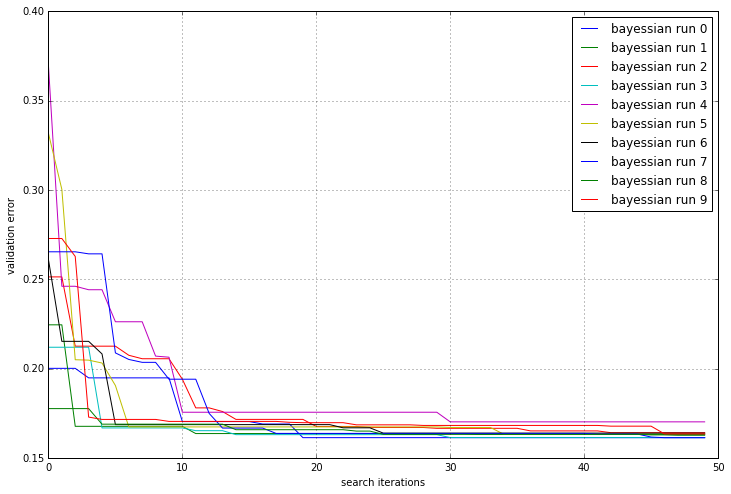

In [96]:
# first a look at the single bayessian runs
plt.figure(figsize=(12, 8))
for i, incs in enumerate(bay_incumbents):
    plt.plot(incs, label="bayessian run {}".format(i))
plt.grid(True)
# plt.yscale('log')
plt.xlabel("search iterations")
plt.ylabel("validation error")
plt.legend(loc='best')

Best found Configuration: by random search
[-2.8195946315580316, 15.376995064127449, 5.296708483203593, 9.919243479663013, 9.863730126263704]
Best found Configuration: by bayessian optimisation
[-2.9400105190638333, 55.925694765700115, 8.093317316970248, 9.410169816571369, 9.736449014907883]


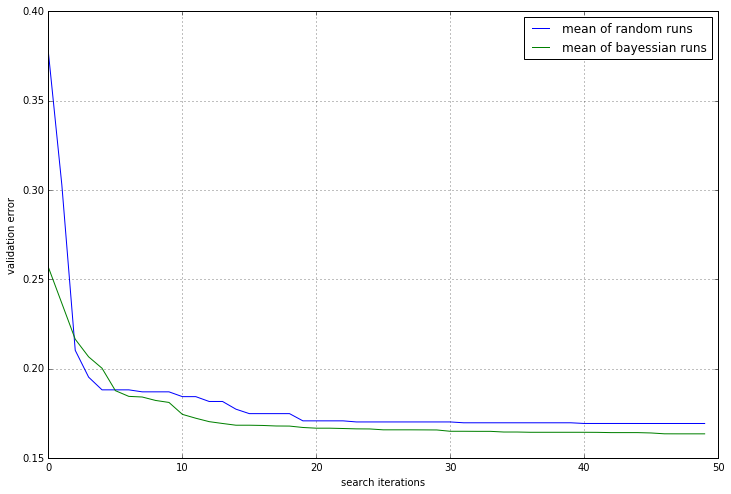

In [99]:
plt.figure(figsize=(12, 8))
plt.plot(np.mean(rand_incumbents, axis = 0), label="mean of random runs")
plt.plot(np.mean(bay_incumbents, axis = 0), label="mean of bayessian runs")

plt.grid(True)
# plt.yscale('log')
plt.xlabel("search iterations")
plt.ylabel("validation error")
plt.legend(loc='best')
print("Best found Configuration: by random search\n{}".format(BestConfig))
print("Best found Configuration: by bayessian optimisation\n{}".format(bay_results[-1]['x_opt']))  # result of last run

During the first 5 iterations the validation error of the average random search decreases faster 
than for the bayessian optimsation (at other runs somewhat slower - there is still quite some random noise). 
Beyond the still prevailing random noise in the results their is a clear trend of the bayession optimisation outperforming the random algorithm for more than 5 and up to 50 runs. 

This might be because the "acquisition function" of the bayessian optimisation algorithm looks for a trade-off between exploration and optimisation. In the early steps of this process, there might be a high incentive to look into unknown / far-off lying regions of the landscape in order to establish a "helicopter" view before trying to optimise within some best region. 

After doing so, when putting a focus on the preferred region, it can optmise its search with some guidance from the previous results, while the random search continues to search "blindly" in the total parameter space and waiting for better results to happen accidentally.

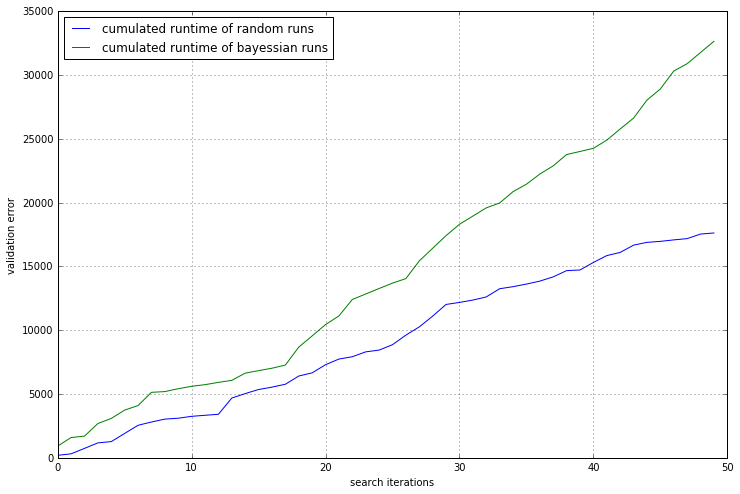

In [100]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(rand_runtimes, axis = 0), label="cumulated runtime of random runs")
plt.plot(np.cumsum(bay_runtimes, axis = 0), label="cumulated runtime of bayessian runs")

plt.grid(True)
# plt.yscale('log')
plt.xlabel("search iterations")
plt.ylabel("validation error")
plt.legend(loc='best')

print()

The runtime of the bayession optimisation is nearly twice as long as for the random optimsation. 

The reason might be, that the bayessian optimisation finds a best configuration with a first hidden layer, that is roughly 7 time larger than the one found by random optimisation (8.09 versus 5.29 on an log2 scale - see printout "best found configurations 2 cells above"). This results in a siginificantly larger total number of parameters, as can be verified via single test runs with the runtime surrogate function. 

One would assume, that an efficient hyperparameter optimisation function would always tend to models with a high number of layers (? overfitting ?), as is the case here, where the bayessian optimiser places all layer sizes near the maximum of 2^10. The drawback of slowing down the model strongly is not "priced in" here. It would be interesting, to add the number of layers as a hyperparameter (here fixed to 3), and eventually somehow incentivise models, which are faster to train. One might for example ask this way: given a limited number of weight parameters what would be the smartest way to arrange them to achieve the best results (variable number and sizes of layers) ? 

In [ ]:
# output dictionary of bayesian_optimization()
'''
“x_opt” : the best found data point
“f_opt” : the corresponding function value
“incumbents”: the incumbent (best found value) after each iteration
“incumbent_values”: the function values of the incumbents
“runtime”: the runtime in seconds after each iteration
“runtime”: the optimization overhead (i.e. time data we do not spend to evaluate the function) of each iteration
“X”: all data points that have been evaluated
“y”: the corresponding function evaluations
'''